## Idea:
How accurately can we measure the position from the autocorrelation?
A simple idea would be to do the full autocorrelation, then fit a Gaussian to the peak at the binary separation.
## Result:
It gave accuracies up to 1e-4 pixels, and shows the signal clearly if it's that size. With 1e-5 pixels, there is a periodogram peak at the right place, but it's not significant (from 100 images, maybe with 1000). (Noise is 100ppm)

## Effects of WFE:
With no WFE, noise stddev is 4.1ppm.\
With 1nm RMS WFE, noise stddev is 5.7ppm.\
With 5nm RMS WFE, noise stddev is 50 ppm.\
With 10nm RMS WFE, noise stddev is 185 ppm.\
With 20nm RMS WFE, noise stddev is 721 ppm. \
With 50nm RMS WFE, noise stddev is 4340 ppm. \
With 100nm RMS WFE, noise stddev is 14386 ppm. 

The signal seems to follow the defocus term, but that might just be luck. \
Going from 0.5wav to -0.35wav is 0.06pix change in sep.\
Going from 0.025wav to -0.015wav is 0.0002 pix change in sep. (i.e. not linear). \
Also putting all of the WFE into one term leads to much worse accuracy than spreading it out.

## Effects of WFE on Larkin Transformed data with Autocorrelation:
With no WFE, noise stddev is 5685 ppm.\
With 1nm RMS WFE, noise stddev is 6643 ppm.\
With 5nm RMS WFE, noise stddev is 6441 ppm.\
With 10nm RMS WFE, noise stddev is 7042 ppm.\
With 20nm RMS WFE, noise stddev is 9335 ppm. \
With 50nm RMS WFE, noise stddev is 18413 ppm. \
With 100nm RMS WFE, noise stddev is 47852 ppm. 

## Effects of WFE on Larkin Transformed data **squared** with Autocorrelation:
With no WFE, noise stddev is 214 ppm.\
With 1nm RMS WFE, noise stddev is 249 ppm.\
With 5nm RMS WFE, noise stddev is 665 ppm.\
With 10nm RMS WFE, noise stddev is 1297 ppm.\
With 20nm RMS WFE, noise stddev is 2665 ppm. \
With 50nm RMS WFE, noise stddev is 7447 ppm. \
With 100nm RMS WFE, noise stddev is 18163 ppm. 

## Effects of individual WFE terms on Autocorrelation:
Tried using same WFE as the 100nm RMS WFE sim above, but using one term only.\
With defocus only (38nm RMS WFE), noise stddev is 2305ppm. First few frames contribute almost all of the scatter, 900ppm otherwise. \
With astigmatism only (58nm RMS WFE), noise stddev is 12025ppm. So it really dominates the final error budget. \
With coma only (42nm RMS WFE), noise stddev is 3767ppm. 

Why is astigmatism so much worse than coma though? Seems like coma is more asymmetric and should be worse...

## Effects of photon noise on Autocorrelation:
1e2 photons peak: 23417 ppm.\
1e3 photons peak: 7555 ppm.\
1e4 photons peak: 2222 ppm.\
1e5 photons peak: 846 ppm.

## Photon noise with background subtraction
I implemented a background subtraction, where the autocorrelation of a single PSF is subtracted first, and then an Airy profile is fit to the residuals (which seems to work better than a Gaussian). The background subtraction was needed to deal with rotations, since the single PSF profile introduces a bias that changes with rotation.\
1e2 photons peak: 22386 ppm.\
1e3 photons peak: 6913 ppm.\
1e4 photons peak: 2002 ppm.\
1e5 photons peak: 719 ppm.

## Photon noise with background subtraction and rotation and jitter:
1e2 photons peak: 25073 ppm.\
1e3 photons peak: 6760 ppm.\
1e4 photons peak: 2160 ppm.\
1e5 photons peak: 742 ppm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/cheetham/Dropbox/code/toliman/Toliman/lib/')
import photometry
sys.path.append('/Users/cheetham/Dropbox/code/toliman/Toliman/COIN/signal_extraction/')
from modelling_functions import autocorrelate,autocorrelation_fit

In [2]:
sim_name = '../sims/zernike_one_star/'
model_PSF = np.load(sim_name+'model_psf.npy')

# sim_name = '../sims/jitter_only/'
# model_PSF = np.load(sim_name+'../../signal_extraction/model_psf.npy')

rough_sep = 44.93
autocor_ratio = 0.68

44.99035175240443
[ 0.39223365 -0.68841904 44.98508453  3.55167727  0.62689876]


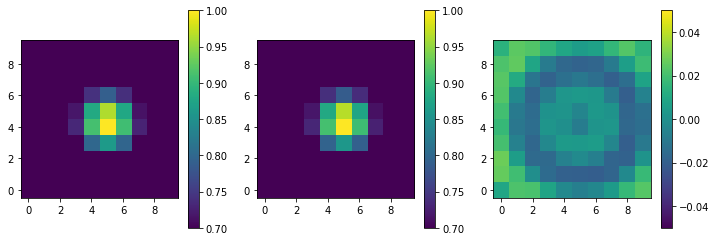

In [3]:
# Test it out
ix = 0
im = np.load(sim_name+"images/{}.npy".format(ix))  
im = im.astype(float)/np.sum(im)

autocor_image = autocorrelate(im,model_PSF=model_PSF,pad=True)

model_autocor = autocorrelate(model_PSF/model_PSF.sum(),model_PSF=model_PSF)

model = autocorrelation_fit(autocor_image-autocor_ratio*model_autocor, plot_resids=True,
                 rough_sep = rough_sep, background_subtracted=True)

sep = np.sqrt(model.x_mean_0[0]**2+model.y_mean_0[0]**2)
print(sep)
print(model.parameters)

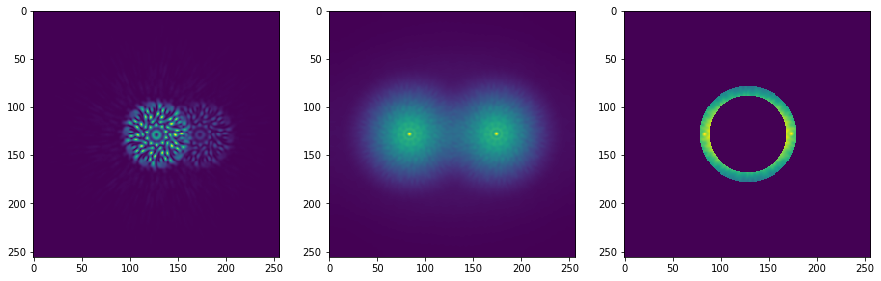

In [4]:
# Show it
im = np.load(sim_name+'images/{}.npy'.format(1))
# im = model_PSF
im = im/im.sum()
autocor = autocorrelate(im,model_PSF=model_PSF)
# autocor = autocorrelate(autocor,model_PSF=model_PSF)

model_autocor = autocorrelate(model_PSF/model_PSF.sum(),model_PSF=model_PSF)

plt.figure(figsize=(15,9))
plt.subplot(131)
plt.imshow(im)


plt.subplot(132)
plt.imshow(autocor-autocor_ratio*model_autocor)

# We know the rough sep
x,y = np.indices(autocor.shape)
R = np.hypot(x-autocor.shape[0]//2,y-autocor.shape[1]//2)
mask = 0*R
mask[np.abs(R-rough_sep)<5] = 1
plt.subplot(133)
plt.imshow(mask*(autocor))
# plt.savefig('/Users/cheetham/Desktop/fig1.pdf')

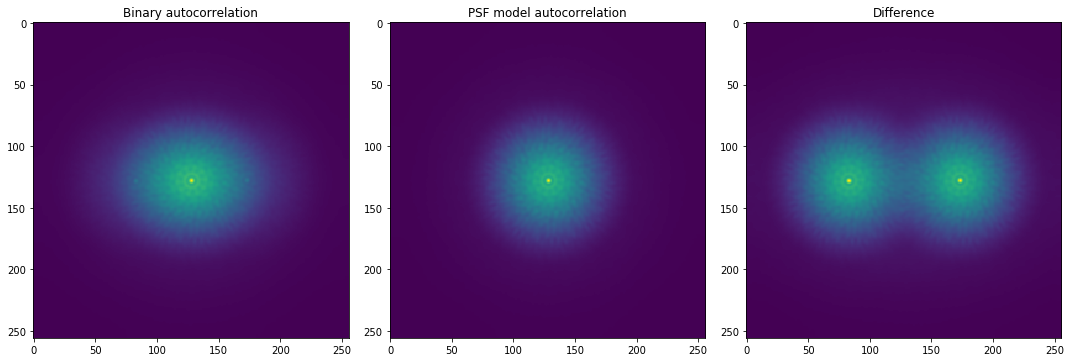

In [5]:
#Another Plot for the report
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.imshow(autocor);plt.title('Binary autocorrelation')
plt.subplot(132)
plt.imshow(model_autocor);plt.title('PSF model autocorrelation')
plt.subplot(133)
plt.imshow(autocor-autocor_ratio*model_autocor);plt.title('Difference')
plt.tight_layout()
# plt.savefig('/Users/cheetham/Google Drive/Backup/astro_things/reports/toliman/autocorrelation_difference.pdf',dpi=500)

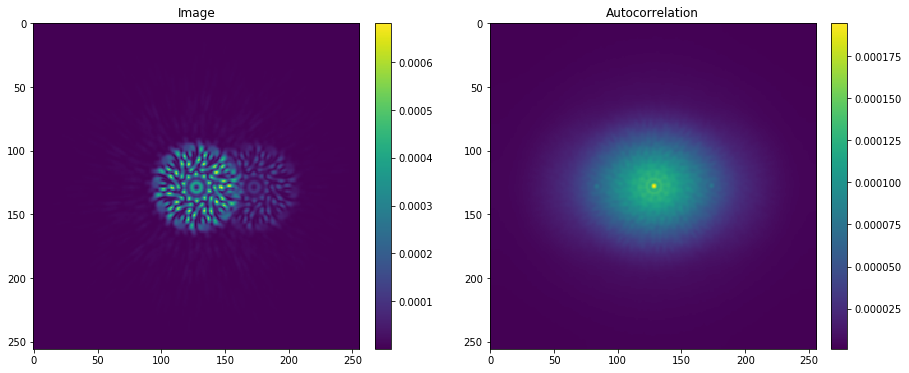

In [6]:
# Plot for the report
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(im);plt.title('Image');plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(autocor);plt.title('Autocorrelation');plt.colorbar(fraction=0.046, pad=0.04)
# import matplotlib as mpl
# circ = mpl.patches.Circle([autocor.shape[0]//2,autocor.shape[1]//2],65,fill=None)
# plt.gca().add_artist(circ)
# plt.savefig('/Users/cheetham/Google Drive/Backup/astro_things/reports/toliman_work/autocorrelation.pdf',dpi=500)

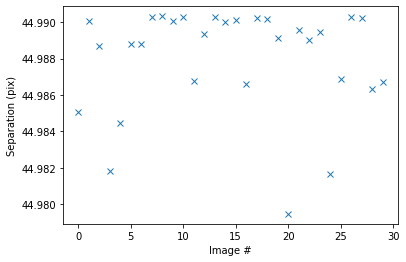

In [7]:
# Loop over some images and fit to them
from IPython.display import clear_output
xs = []
ys = []
seps = []
autocor_ratio = 0.68
background_subtracted = True
for ix in range(30):
    im = np.load(sim_name+"images/{}.npy".format(ix))
    
    autocor_image = autocorrelate(im/np.sum(im),model_PSF=model_PSF,pad=True)
    
    # Subtract the background?
    if background_subtracted:
        autocor_image -= autocor_ratio*model_autocor
    
    model = autocorrelation_fit(autocor_image,plot_resids=False,rough_sep=rough_sep,background_subtracted=background_subtracted)
    
    new_x = model.x_mean_0[0]
    new_y = model.y_mean_0[0]
        
    new_sep = np.sqrt(new_x**2+new_y**2)
    xs.append(new_x)
    ys.append(new_y)
    seps.append(new_sep)
    
    clear_output(wait=True)
    plt.plot(ys,'x')
    plt.xlabel('Image #')
    plt.ylabel('Separation (pix)')
    plt.show()

xs = np.array(xs)
ys = np.array(ys)
seps = np.array(seps)

<Figure size 432x288 with 0 Axes>

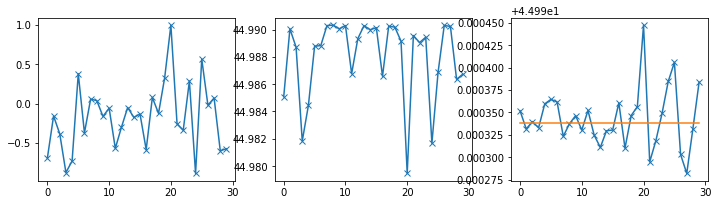

In [8]:
# Can we see the signal?
signal = np.loadtxt(sim_name+'signal.csv',skiprows=1,delimiter=',')
plt.clf()
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.plot(xs,'-x')

plt.subplot(132)
plt.plot(ys,'-x')

plt.subplot(133)
plt.plot(seps,'-x')
plt.plot(signal[:len(seps),1]+np.median(seps))
# plt.plot(signal[:,1])

(-0.017675480865806278, 0.39961227313690384)

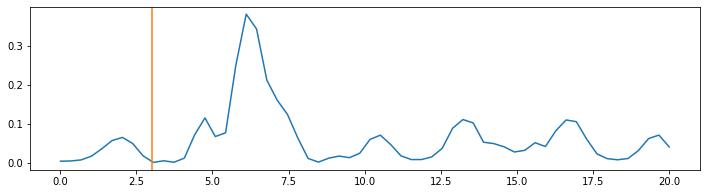

In [9]:
# Can we see the signal in a periodogram
from astropy.timeseries import LombScargle
frequency = np.linspace(0.01, 20., len(xs)*2)
t = np.arange(xs.shape[0])/xs.shape[0]
plt.figure(figsize=(12,3))
power = LombScargle(t, seps).power(frequency)
plt.plot(frequency,power)
yl = plt.ylim()
plt.plot([3.,3.],yl,'-')
plt.ylim(yl)

In [10]:
print('X,Y scatter in ppm:',np.std(xs)*1e6,np.std(ys)*1e6)
print('Sep accuracy in ppm:',np.std(seps-signal[0:len(seps),1])*1e6)
print(sim_name)

X,Y scatter in ppm: 421074.0123367003 2883.803235655366
Sep accuracy in ppm: 32.66989587722787
../sims/zernike_one_star/


In [11]:
# What's the offset from the true value? Seems to be 0.125 pixel for the sim with jitter only.
print(np.median(seps))
print(np.median(seps)-44.91985222)
# print(np.median(seps)-37.81546712654381)

44.990338531392254
0.07048631139225137


7.927990962449297e-10


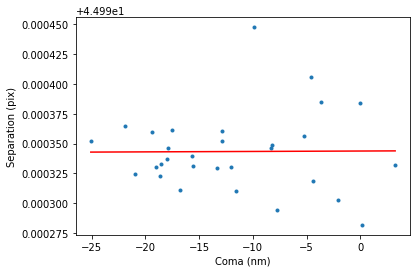

In [12]:
# Are the residuals correlated with anything?
error_term = np.loadtxt(sim_name+'wfe.csv',skiprows=1,delimiter=',')[:,3]

plt.plot(error_term*1e9,seps,'.')
# plt.plot(error_term*1e9,ys,'.')
# plt.plot(error_term*1e9,xs,'.')
plt.xlabel('Coma (nm)')
plt.ylabel('Separation (pix)')

# Plot a straight line fit
coeffs = np.polyfit(error_term*1e9,seps,deg=1)
plot_xs = np.linspace(np.min(error_term*1e9),np.max(error_term*1e9))
plot_ys = coeffs[1]+coeffs[0]*plot_xs
plt.plot(plot_xs,plot_ys,'r')
print(coeffs[0]/np.mean(seps))